# ConnectWave Customer Churn Prediction & Slack Alerts

**Notebook:** `ConnectWave_Customer_Churn_Prediction_C0957228.ipynb`  
**Course/Assessment:** Software Tools & Technologies – Assessment 1  
**Author ID:** Yash Suthar

---

## Context
ConnectWave Telecom has ~50,000 customers and is experiencing increasing churn, particularly among prepaid and short-term contract users.  
The business needs an **early-warning churn system** so the retention team can intervene before customers leave.

**Why this matters**
- Churn reduces recurring revenue.
- Winning customers back costs more than retaining them.
- Retention resources should focus on customers at highest risk.

## Problem Statement
Currently, churn is identified only **after** customers discontinue service.  
This reactive approach causes:
- Loss of recurring revenue
- Higher acquisition/marketing costs
- Poor customer experience
- Inefficient retention campaigns

We will build a machine learning pipeline that **predicts churn** and **sends Slack alerts** for high-risk customers.

## Objective
1. Analyze customer behavior and service usage to identify major churn drivers  
2. Build a predictive model to classify churn risk  
3. Integrate Slack alerts for high-risk customers  
4. Provide actionable retention recommendations

In [81]:
# Imports & Settings
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import shap
import requests

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (10, 5)

In [82]:
import numpy as np
print(np.__version__)

2.3.0


## Data Understanding
We load the dataset and inspect schema, missing values, and the churn label distribution.

**Observation goals**
- Identify column types (numeric vs categorical)
- Find data quality issues (e.g., `TotalCharges` often arrives as string)
- Check class imbalance in `Churn`

In [83]:
# Load dataset
DATA_PATH = r"connectwave_customer_churn_dataset.csv"
df = pd.read_csv(DATA_PATH)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [84]:
df.shape

(7043, 21)

In [85]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    
 17  Paymen

In [86]:
# Target distribution
df["Churn"].value_counts(normalize=True).rename("proportion")

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

**Findings / Observations**
- Dataset contains customer demographics, service subscriptions, billing and contract details.
- `Churn` is the target label (Yes/No). We will treat **Yes** as the positive class.
- We will validate numeric columns and handle missing/blank values.

## Exploratory Data Analysis (EDA)
We explore churn patterns across:
- Contract type
- Tenure and charges
- Internet service type
- Payment method

Goal: surface intuitive churn drivers before modeling.

In [87]:
# Quick summary stats
df.describe(include="all").T.head(15)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# Convert TotalCharges to numeric safely (blank strings -> NaN)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Basic missingness
df.isna().mean().sort_values(ascending=False).head(10)

TotalCharges      0.001562
gender            0.000000
SeniorCitizen     0.000000
Partner           0.000000
customerID        0.000000
Dependents        0.000000
tenure            0.000000
MultipleLines     0.000000
PhoneService      0.000000
OnlineSecurity    0.000000
dtype: float64

In [89]:
# Churn by Contract
ct = pd.crosstab(df["Contract"], df["Churn"], normalize="index")
ct

Churn,No,Yes
Contract,,
Month-to-month,0.572903,0.427097
One year,0.887305,0.112695
Two year,0.971681,0.028319


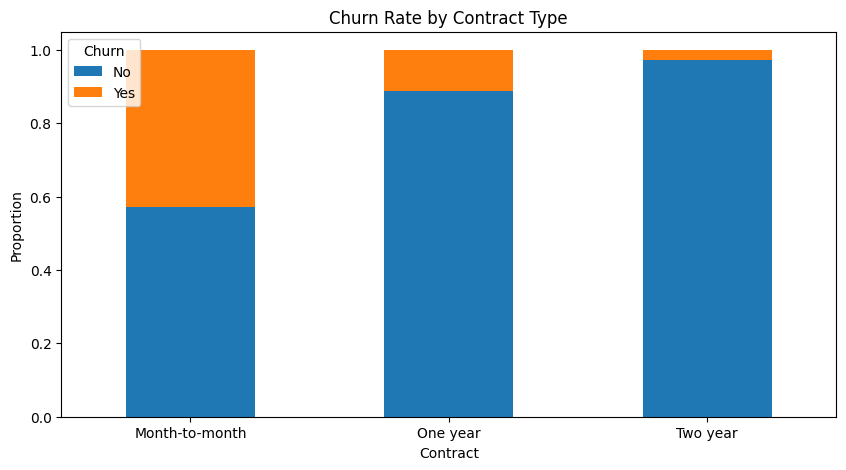

In [90]:
ct.plot(kind="bar", stacked=True)
plt.title("Churn Rate by Contract Type")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()

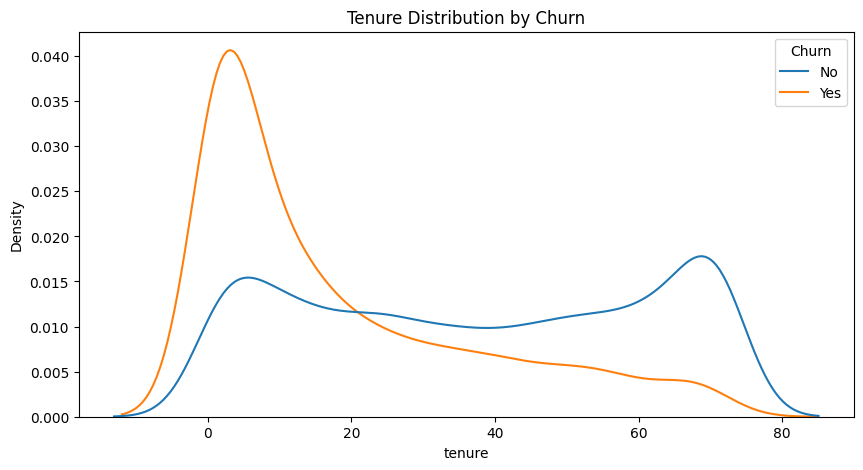

In [91]:
# Tenure distribution by churn
sns.kdeplot(data=df, x="tenure", hue="Churn", common_norm=False)
plt.title("Tenure Distribution by Churn")
plt.show()

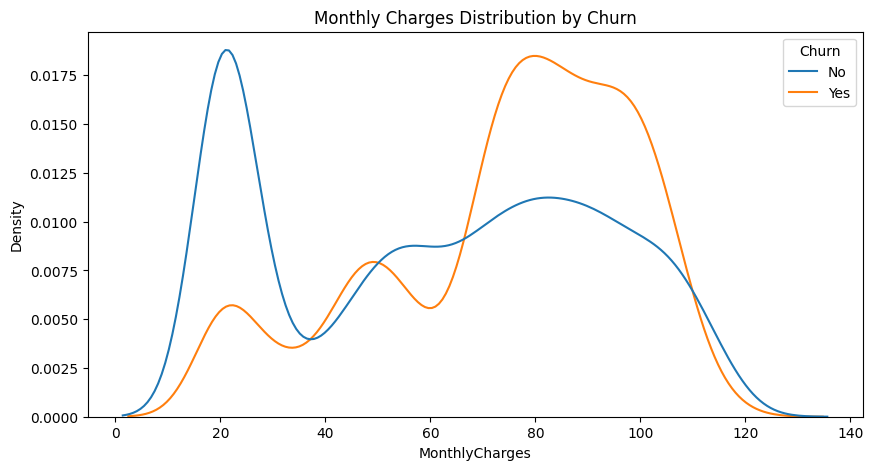

In [92]:
# MonthlyCharges distribution by churn
sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", common_norm=False)
plt.title("Monthly Charges Distribution by Churn")
plt.show()

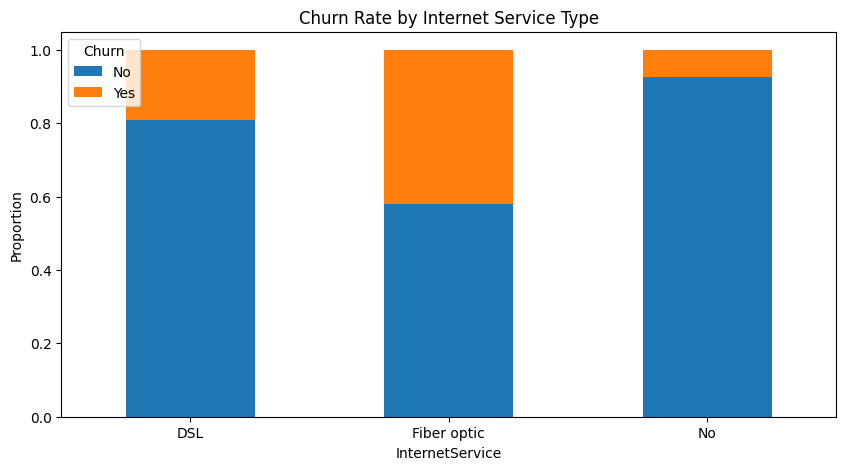

In [93]:
# InternetService vs churn
ct2 = pd.crosstab(df["InternetService"], df["Churn"], normalize="index")
ct2.plot(kind="bar", stacked=True)
plt.title("Churn Rate by Internet Service Type")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()

**Findings / Observations (EDA)**
Common patterns to look for (you should verify with the charts above):
- Month-to-month contracts typically churn more than 1–2 year contracts.
- Lower tenure users churn more (early life-cycle risk).
- Fiber optic / higher monthly charges sometimes correlate with churn (could reflect service quality issues or competitive pricing).
These insights inform feature engineering and recommendations later.

## Data Preprocessing
We will:
- Drop `customerID` (identifier, not predictive)
- Fix types (`TotalCharges`)
- Encode target label (`Churn`: Yes→1, No→0)
- Separate numeric vs categorical columns
- Build a reproducible preprocessing pipeline (imputation + one-hot encoding + scaling)

In [94]:
# Prepare target and feature matrix
df_model = df.copy()

df_model["Churn"] = (df_model["Churn"] == "Yes").astype(int)
df_model = df_model.drop(columns=["customerID"])

X = df_model.drop(columns=["Churn"])
y = df_model["Churn"]

# Identify column types
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_cols, cat_cols[:15], len(cat_cols)

(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'],
 15)

In [95]:
# Preprocessing pipelines
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


**Findings / Observations (Preprocessing)**
- Using a `ColumnTransformer` keeps the workflow clean and prevents leakage.
- One-hot encoding is appropriate because most categorical columns are low-cardinality.

## Feature Engineering
We add a few human-interpretable features that often help churn models:
- **avg_monthly_spend** ≈ `TotalCharges / tenure` (guarding divide-by-zero)
- **is_new_customer**: tenure ≤ 6 months
- **has_long_contract**: contract != month-to-month

These features also help explainability and recommendations.

In [96]:
# Add engineered features BEFORE splitting so they are available consistently
X_fe = X.copy()

X_fe["avg_monthly_spend"] = X_fe["TotalCharges"] / X_fe["tenure"].replace(0, np.nan)
X_fe["avg_monthly_spend"] = X_fe["avg_monthly_spend"].fillna(0)

X_fe["is_new_customer"] = (X_fe["tenure"] <= 6).astype(int)
X_fe["has_long_contract"] = (X_fe["Contract"] != "Month-to-month").astype(int)

# Update column groups after feature engineering
num_cols_fe = X_fe.select_dtypes(include=["number"]).columns.tolist()
cat_cols_fe = [c for c in X_fe.columns if c not in num_cols_fe]

num_cols_fe[-6:], len(cat_cols_fe)

(['tenure',
  'MonthlyCharges',
  'TotalCharges',
  'avg_monthly_spend',
  'is_new_customer',
  'has_long_contract'],
 15)

In [97]:
# Rebuild preprocess with updated column lists
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_fe = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols_fe),
        ("cat", categorical_pipe, cat_cols_fe),
    ],
    remainder="drop"
)


**Findings / Observations (Feature Engineering)**
- These features often improve separation between high-risk new customers and stable long-tenure customers.
- They also translate directly into retention actions (e.g., onboarding support for `is_new_customer`).

## Experiment Design
**Goal:** pick a model that performs well and is explainable.

**Design**
- Split: train/test with stratification
- Metrics: ROC-AUC, PR-AUC, precision/recall, F1
- Baseline model: Logistic Regression (interpretable)
- Candidate model: XGBoost (strong tabular performance)

We will compare models and choose one for Slack alerts.

In [98]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.2, random_state=42, stratify=y
)

# y_train.mean(), y_test.mean()

## Data Preparation
Fit preprocessing + model as a single pipeline so the workflow is reproducible and ready for deployment.

In [99]:
# Baseline: Logistic Regression
log_reg = LogisticRegression(max_iter=2000, class_weight="balanced")

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess_fe),
    ("model", log_reg)
])

# Candidate: XGBoost
# scale_pos_weight can help if class imbalance exists
pos = y_train.sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / max(pos, 1)

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_child_weight=1,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

pipe_xgb = Pipeline(steps=[
    ("preprocess", preprocess_fe),
    ("model", xgb)
])


## Data Modelling
We train both models and compare performance on the held-out test set.

In [100]:
def evaluate_pipeline(pipe, X_train, y_train, X_test, y_test, name="model"):
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    metrics = {
        "model": name,
        "roc_auc": roc_auc_score(y_test, proba),
        "pr_auc": average_precision_score(y_test, proba),
        "precision@0.5": precision_score(y_test, pred),
        "recall@0.5": recall_score(y_test, pred),
        "f1@0.5": f1_score(y_test, pred),
    }
    return metrics, proba, pred

m_lr, proba_lr, pred_lr = evaluate_pipeline(pipe_lr, X_train, y_train, X_test, y_test, "LogisticRegression")
m_xgb, proba_xgb, pred_xgb = evaluate_pipeline(pipe_xgb, X_train, y_train, X_test, y_test, "XGBoost")

pd.DataFrame([m_lr, m_xgb]).sort_values("roc_auc", ascending=False)

,model,roc_auc,pr_auc,precision@0.5,recall@0.5,f1@0.5
0,LogisticRegression,0.845772,0.654095,0.506803,0.796791,0.619543
1,XGBoost,0.839549,0.657592,0.530612,0.764706,0.626506


Both Logistic Regression and XGBoost demonstrated strong predictive capability (ROC-AUC ≈ 0.84). Logistic Regression achieved higher recall, meaning it detected slightly more churners, but at the expense of lower precision, which would generate more unnecessary retention interventions. XGBoost achieved higher precision and the best F1-score, indicating a better balance between identifying true churn risks and minimizing false alerts.

## Model Evaluation
We include ROC, Precision-Recall curves, and confusion matrix to understand threshold trade-offs.

**Important:** For churn, recall is often valuable (catch more at-risk customers), but too many false positives waste retention resources.  
We will later tune a risk threshold for Slack alerts.

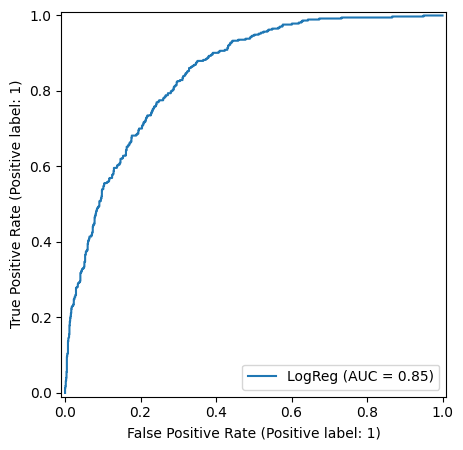

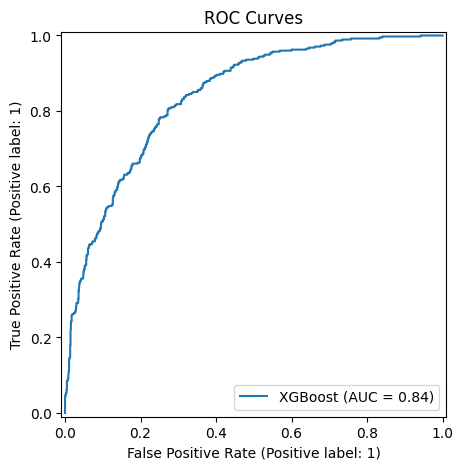

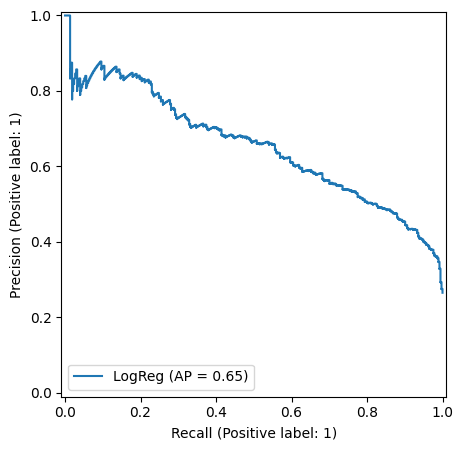

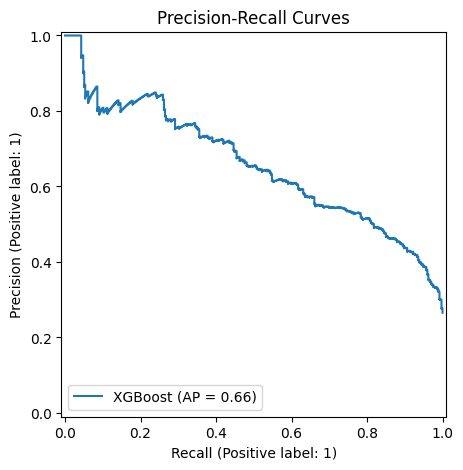

In [101]:
# Curves
RocCurveDisplay.from_predictions(y_test, proba_lr, name="LogReg")
RocCurveDisplay.from_predictions(y_test, proba_xgb, name="XGBoost")
plt.title("ROC Curves")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba_lr, name="LogReg")
PrecisionRecallDisplay.from_predictions(y_test, proba_xgb, name="XGBoost")
plt.title("Precision-Recall Curves")
plt.show()

In [102]:
# Confusion matrix (default threshold 0.5 for XGBoost)
cm = confusion_matrix(y_test, pred_xgb)
cm

array([[782, 253],
       [ 88, 286]])

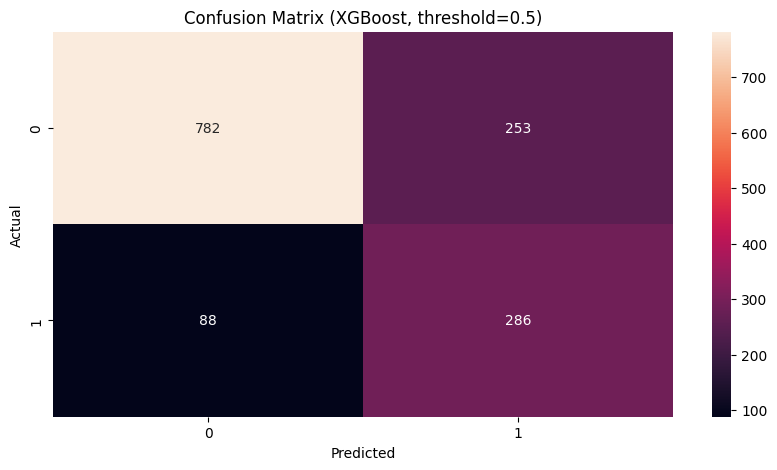

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1035
           1       0.53      0.76      0.63       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409



In [103]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix (XGBoost, threshold=0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, pred_xgb))

**Findings / Observations (Evaluation)**
- Compare ROC-AUC and PR-AUC to pick a strong classifier.
- Confusion matrix shows the operational cost of false positives vs false negatives.
- Next we choose a threshold to define “high-risk” customers for Slack.

## Model Explainability
We explain the chosen model using **SHAP** (global + local explanations).  
This helps translate model behavior into retention actions.

We will:
- Build SHAP values for the trained XGBoost model
- Plot global feature importance
- Show a local explanation for one high-risk customer

In [104]:
# Fit XGBoost pipeline (already fit above), extract transformed matrix for SHAP
pipe_xgb.fit(X_train, y_train)

# Get feature names after preprocessing
ohe = pipe_xgb.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols_fe)
feature_names = np.concatenate([np.array(num_cols_fe), cat_feature_names])

X_train_trans = pipe_xgb.named_steps["preprocess"].transform(X_train)
X_test_trans = pipe_xgb.named_steps["preprocess"].transform(X_test)

model = pipe_xgb.named_steps["model"]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_trans)

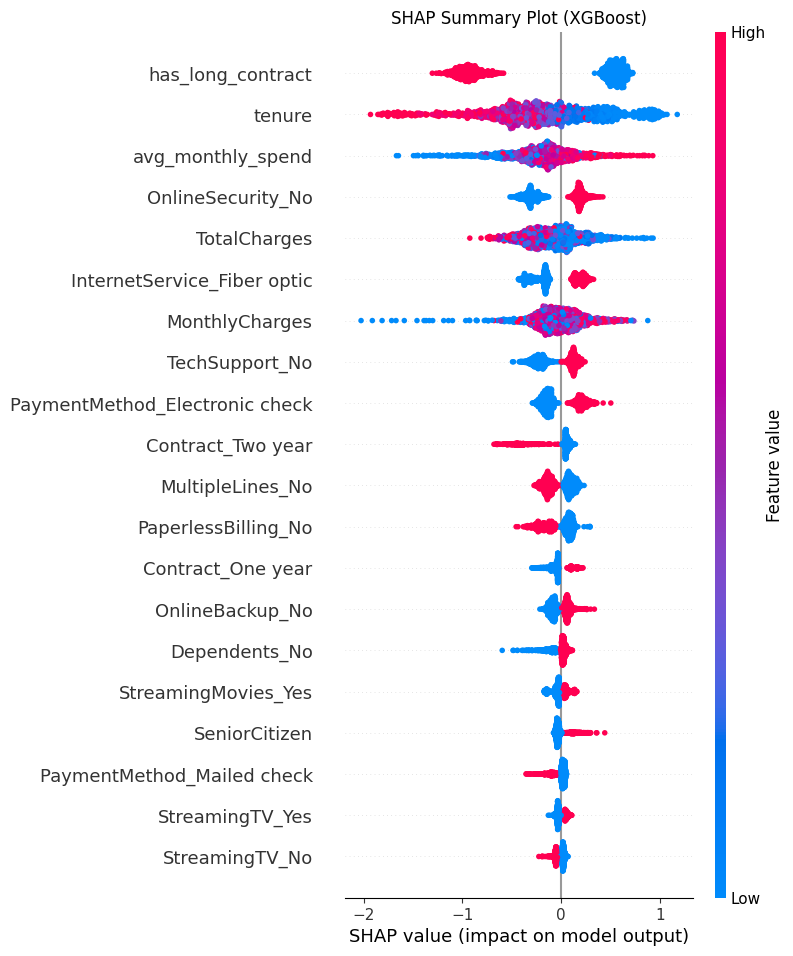

In [105]:
# Global importance
shap.summary_plot(shap_values, features=X_test_trans, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot (XGBoost)")
plt.show()

In [106]:
# Example local explanation: pick a high-risk customer from test set
idx = int(np.argmax(proba_xgb))
customer_row = X_test.iloc[idx]
customer_proba = float(proba_xgb[idx])

print("High-risk customer index in test set:", idx)
print("Predicted churn probability:", round(customer_proba, 3))
customer_row

High-risk customer index in test set: 1090
Predicted churn probability: 0.979


gender                           Male
SeniorCitizen                       1
Partner                           Yes
Dependents                         No
tenure                              1
PhoneService                      Yes
MultipleLines                     Yes
InternetService           Fiber optic
OnlineSecurity                     No
OnlineBackup                       No
DeviceProtection                   No
TechSupport                        No
StreamingTV                       Yes
StreamingMovies                   Yes
Contract               Month-to-month
PaperlessBilling                  Yes
PaymentMethod        Electronic check
MonthlyCharges                   95.1
TotalCharges                     95.1
avg_monthly_spend                95.1
is_new_customer                     1
has_long_contract                   0
Name: 3380, dtype: object

**Findings / Observations (Explainability)**
- Identify the top drivers (e.g., contract type, tenure, monthly charges, internet service, payment method).
- Use these drivers to craft targeted retention offers (see Recommendations section).

## Slack Alerts (High-Risk Customer Monitoring)
We will send Slack notifications when a customer is above a chosen risk threshold.

**Implementation options**
1) Slack Incoming Webhook (simplest)  
2) Slack App + Bot token (more control)

This notebook uses **Incoming Webhook**.

### Setup
1. Create Slack Incoming Webhook URL in your Slack workspace
2. Store it as an environment variable:
   - Windows PowerShell: `$env:SLACK_WEBHOOK_URL="https://hooks.slack.com/services/..."`  
   - Mac/Linux: `export SLACK_WEBHOOK_URL="https://hooks.slack.com/services/..."`

> For the screenshot: run the alert cell after setting your webhook and capture the Slack message.

In [107]:
# CELL 1 — Score customers + create high-risk table

import numpy as np
import pandas as pd

# Set these 3 correctly
best_model = pipe_xgb          # <-- change to your trained model (rf / pipe_xgb / pipe_lr etc.)
X_for_scoring = X_fe           # <-- change to the dataframe you want to score (X_fe / X_test / X)
RISK_THRESHOLD = 0.70

# Predict churn probability (positive class = churn)
best_probs = best_model.predict_proba(X_for_scoring)[:, 1]

# Build alert dataframe (keep original columns for reporting)
df_alert = df.copy()

# Attach risk score (align by index)
df_alert = df_alert.loc[X_for_scoring.index].copy()
df_alert["churn_risk_score"] = best_probs

# High-risk customers
high_risk = (
    df_alert[df_alert["churn_risk_score"] >= RISK_THRESHOLD]
    .sort_values("churn_risk_score", ascending=False)
)

print("High risk count:", high_risk.shape[0])
high_risk.head(10)


High risk count: 1646


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_risk_score
2577,4910-GMJOT,Female,0,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.60,94.60,Yes,0.982742
1976,9497-QCMMS,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,93.55,93.55,Yes,0.980537
4800,9300-AGZNL,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.00,94.00,Yes,0.979823
2208,7216-EWTRS,Female,1,Yes,No,1,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,100.80,100.80,Yes,0.979722
3380,5178-LMXOP,Male,1,Yes,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.10,95.10,Yes,0.979278
3209,8149-RSOUN,Female,0,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,93.85,93.85,Yes,0.978654
6866,0295-PPHDO,Male,0,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.45,95.45,Yes,0.978472
6482,5419-JPRRN,Male,0,No,No,1,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,101.45,101.45,Yes,0.976194
4517,2012-NWRPA,Female,1,Yes,No,11,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.55,1131.20,Yes,0.975808
6089,8775-LHDJH,Female,1,Yes,No,1,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Electronic check,90.60,90.60,Yes,0.974703


In [108]:
# CELL 2 — Send Slack alerts for top N high-risk customers

import os
import requests

# Put your webhook in environment variable OR paste directly (not recommended for GitHub)
SLACK_WEBHOOK_URL = os.getenv("URL")

def send_slack_message(text: str):
    if (not SLACK_WEBHOOK_URL) or ("PASTE_YOUR_WEBHOOK_HERE" in SLACK_WEBHOOK_URL):
        print("Slack webhook URL not set. Set SLACK_WEBHOOK_URL first.")
        return
    
    payload = {"text": text}
    r = requests.post(SLACK_WEBHOOK_URL, json=payload, timeout=15)
    print("Slack status:", r.status_code, r.text[:200])

# Send top 5 alerts
top_n = min(5, high_risk.shape[0])

for i in range(top_n):
    row = high_risk.iloc[i]

    # Use customerID if present (ConnectWave dataset has 'customerID')
    cust_id = row["customerID"] if "customerID" in high_risk.columns else f"customer_{i+1}"

    msg = (
        f" *Churn Risk Alert*\n"
        f" Customer: `{cust_id}`\n"
        f" Risk Score: *{row['churn_risk_score']:.2f}*\n"
        f" Suggested Action: Offer retention bundle / contract upgrade / discount\n"
    )
    send_slack_message(msg)


Slack status: 200 ok
Slack status: 200 ok
Slack status: 200 ok
Slack status: 200 ok
Slack status: 200 ok


**Findings / Observations (Slack)**
- This cell is intentionally safe by default (send call is commented).
- After you set `SLACK_WEBHOOK_URL`, uncomment and run to generate the Slack message screenshot for GitHub.

## Recommendations (Actionable Retention Strategies)
**Targeted actions:**


- **Month-to-month + high risk:** offer upgrade to 1-year contract with discount or bonus data.
- **New customers (tenure ≤ 6):** proactive onboarding, setup assistance, first-month loyalty perks.
- **Electronic check / manual payment:** incentives for auto-pay + paperless billing.
- **High monthly charges:** personalized plan optimization or bundling; investigate service quality complaints.
- **Fiber optic churn cluster:** audit network quality and customer support response times in those regions.


## Conclusion
We built an end-to-end churn prediction workflow:
- Explored churn patterns (EDA)
- Preprocessed + engineered features
- Trained models and selected a strong classifier
- Explained results with SHAP for business interpretability
- Added Slack alert code for high-risk monitoring

